# Nuclei segmentation

More details in:

https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html

https://github.com/broadinstitute/Tangram/blob/master/tangram_tutorial.ipynb

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage

# import tangram for spatial deconvolution
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

print(f"tangram=={tg.__version__}")

%load_ext autoreload
%autoreload 2
#%load_ext lab_black

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==1.0 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4
squidpy==1.1.2
tangram==1.0.0


## Create the image container

Takes quite a while to load, the file is only 136M large, but python uses over 33Gb memory and the kernel crashes.

Load smaller proportion of the image instead.

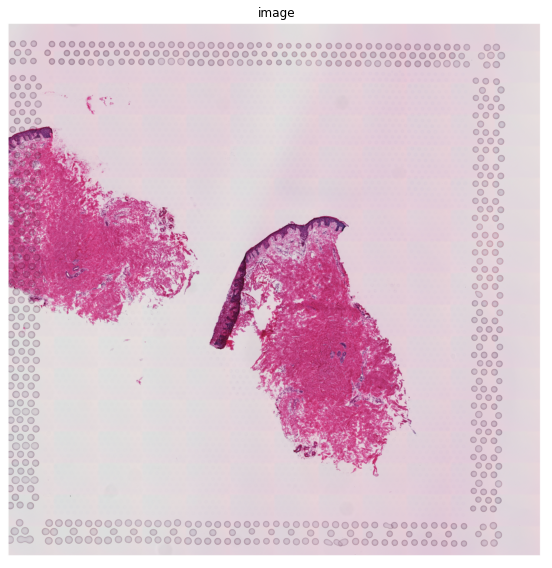

In [4]:
#img_path = "../../../spatial/rawdata/images/Donor_1/201006_P17401_V10J29-111_AM.A1-Spot000001.jpg" 
# original image, crashes on load
# 47616 × 47616 pixels

# smaller part of the image, works to load, but will not have correct scale
img_path = "../../../spatial/rawdata/images/Donor_1/cropped_A1.jpg" # works to load a smaller part of the figure.
sf = 1
#img_path = "/Users/asbj/201006_P17401_V10J29-111_AM.A1-Spot000001_lev2.jpg" #smaller with preview

# highres image 2000 x 2000 pixels
img_path = "../../../spatial/rawdata/Donor_1/P17401_1001/spatial/tissue_hires_image.png"
sf =  0.04200269

img = sq.im.ImageContainer(img_path, scale=sf)

img.show()

# Nuclei segmentation

For segmentation of H&E images, following more or less this tutorial: brain_segment_hne.html


Crop thee image even further

In [5]:
img

ImageContainer[shape=(2000, 2000), layers=['image']]

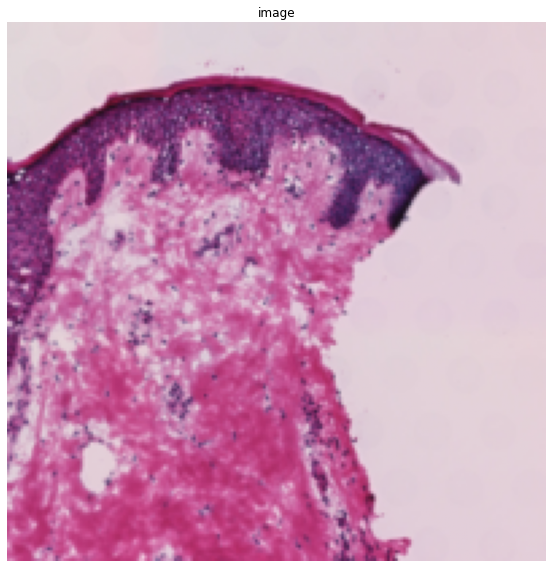

In [27]:
#crop = img.crop_corner( 1000, 3000, size=(1500,1500 ), scale=1) # with cropped image
crop = img.crop_corner( 700, 1100, size=(200,200 ), scale=1)


crop.show(layer="image")



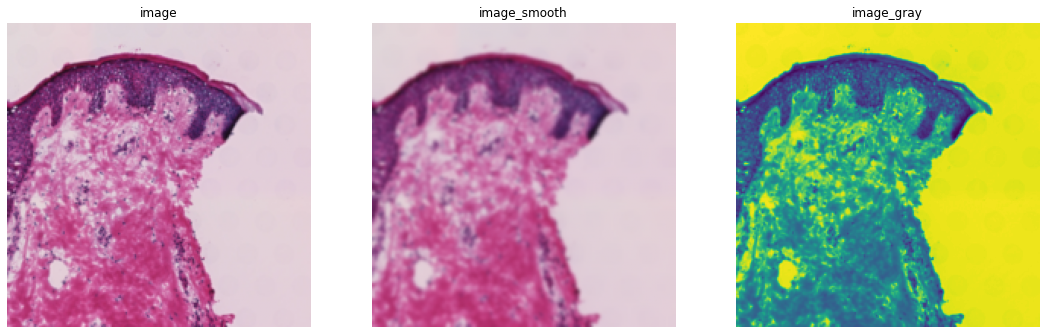

In [28]:
# smooth image
sq.im.process(crop, layer="image", method="smooth")
sq.im.process(crop, layer="image", method="gray")
#sq.im.process(crop, layer="image", method="smooth", sigma=4)

# plot the result
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)
for layer, ax in zip(["image", "image_smooth", "image_gray"], axes):
    crop.show(layer, ax=ax)
    ax.set_title(layer)
    



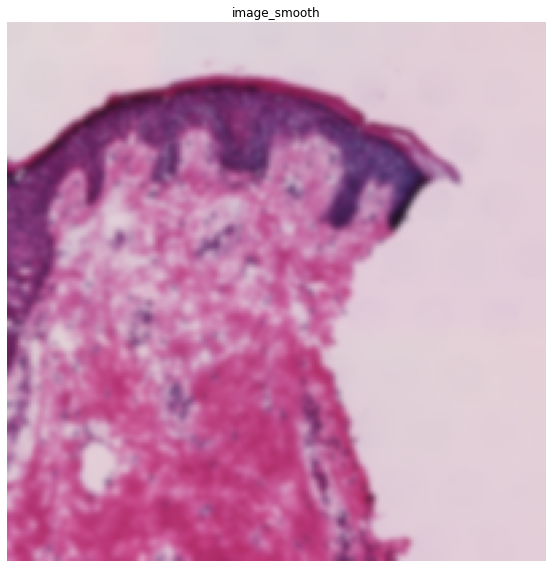

In [29]:
crop.show("image_smooth")
# smoother image clearly looks to blurred

In [30]:
crop

ImageContainer[shape=(200, 200), layers=['image', 'image_gray', 'image_smooth']]

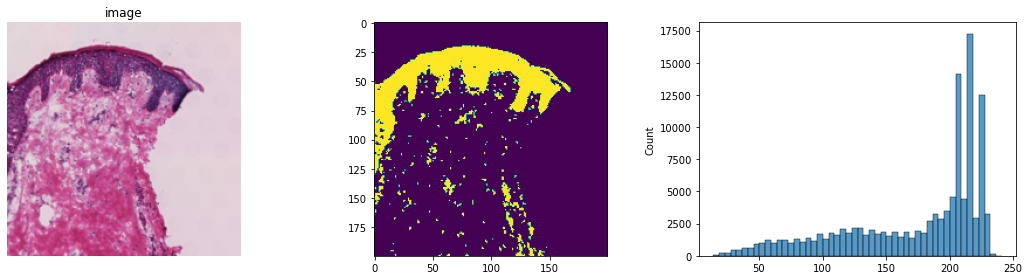

In [36]:
import seaborn as sns

# use unsmother image
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
crop.show("image", cmap="gray", ax=axes[0])
axes[1].imshow(crop["image"][:, :, 0, 0] < 170)
_ = sns.histplot(np.array(crop["image"]).flatten(), bins=50, ax=axes[2])
plt.tight_layout()


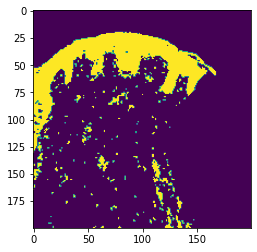

In [38]:
plt.imshow(crop["image"][:, :, 0, 0] < 170)

Judging from the histogram in the third plot we decide on a cutoff for the intensities (in this example 0.6) and in the middle image, all pixels above that level are shown.

In [39]:
sq.im.segment(crop, layer="image", method="watershed", thresh=170, geq=False)



ImageContainer[shape=(200, 200), layers=['image', 'image_gray', 'image_smooth', 'segmented_watershed']]
Number of segments in crop: 303


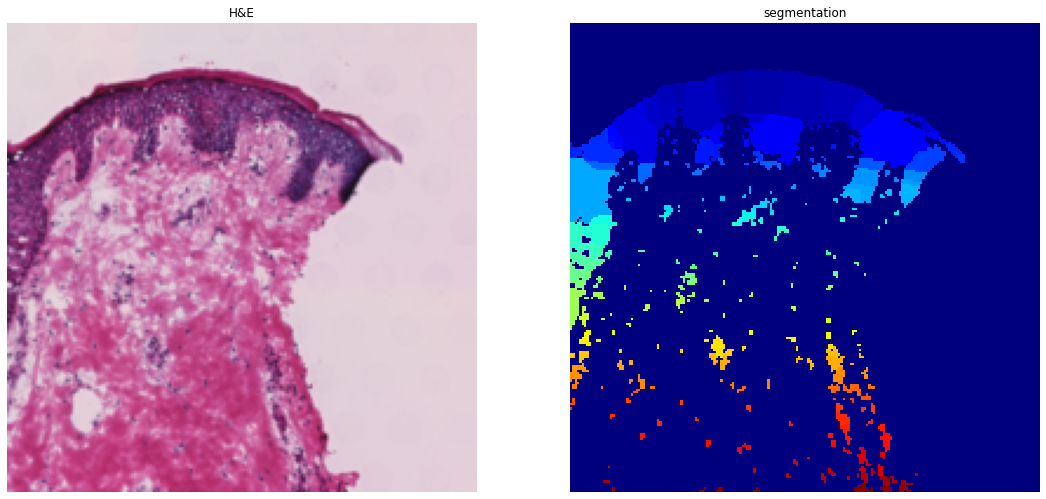

In [40]:
print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_watershed']))}")

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)
crop.show("image", cmap="gray", ax=axes[0])
_ = axes[0].set_title("H&E")
crop.show("segmented_watershed", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")

In [41]:
# in tutorial with DAPI stain

# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}
# calculate segmentation features
sq.im.calculate_image_features(
    adata_st,
    crop,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
    library_id = sample
)

NameError: name 'adata_st' is not defined

In [42]:

crop['segmented_watershed'].data[100:200,100:200]

array([[[[0]],

        [[0]],

        [[0]],

        ...,

        [[0]],

        [[0]],

        [[0]]],


       [[[0]],

        [[0]],

        [[0]],

        ...,

        [[0]],

        [[0]],

        [[0]]],


       [[[0]],

        [[0]],

        [[0]],

        ...,

        [[0]],

        [[0]],

        [[0]]],


       ...,


       [[[0]],

        [[0]],

        [[0]],

        ...,

        [[0]],

        [[0]],

        [[0]]],


       [[[0]],

        [[0]],

        [[0]],

        ...,

        [[0]],

        [[0]],

        [[0]]],


       [[[0]],

        [[0]],

        [[0]],

        ...,

        [[0]],

        [[0]],

        [[0]]]], dtype=uint32)

In [43]:
adata_st.obsm["image_features"]["segmentation_label"].value_counts()

NameError: name 'adata_st' is not defined

In [ ]:
adata_st.obsm['image_features']

In [ ]:
adata_st.obs["cell_count"] = adata_st.obsm["image_features"]["segmentation_label"]
sc.pl.spatial(adata_st, color=["clusters", "cell_count"], frameon=False, library_id = sample)

Predicted number of cells vs counts/genes

In [ ]:
sc.pl.scatter(adata_st, "cell_count", "total_counts", color = "clusters")
sc.pl.scatter(adata_st, "cell_count", "n_genes_by_counts", color = "clusters")

In [ ]:
# violins can only be done with categorical values, not numeric.

adata_st.obs["cell_count_cat"] = adata_st.obs["cell_count"].astype("category")

sc.pl.violin(adata_st,"total_counts", "cell_count_cat")


## Run Tangram 

In [ ]:
tg.pp_adatas(adata_sc, adata_st, genes=genes)

In [ ]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="constrained",
    target_count=adata_st.obs.cell_count.sum(),
    density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
    device="cpu",
)

In [ ]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")


In [ ]:
adata_st.obs = pd.concat([adata_st.obs, adata_st.obsm["tangram_ct_pred"]], axis=1)


In [ ]:
adata_st.obsm["tangram_ct_pred"]["Astro"]

sc.pl.spatial(
    adata_st,
    library_id = sample,
    color=["Astro"],
)

In [ ]:
sc.pl.spatial(
    adata_st,
    library_id = sample,
    color=["L2/3 IT", "L4", "L5 IT", "L5 PT", "L6 CT", "L6 IT", "L6b"],
)

In [ ]:
adata_st.obs.columns

In [ ]:
tg.create_segment_cell_df(adata_st)

In [ ]:
adata_st.uns["tangram_cell_segmentation"].head()


In [ ]:
tg.count_cell_annotations(
    ad_map,
    adata_sc,
    adata_st,
    annotation="cell_subclass",
)

In [ ]:
adata_st.obsm["tangram_ct_count"].head()

In [ ]:
adata_segment = tg.deconvolve_cell_annotations(adata_st)


In [ ]:
adata_segment.obs.head()


In [ ]:
# Positions predicted by tangram are not related to the hires image 

In [ ]:
print(adata_segment.shape)
print(adata_st.shape)

# now have 774 cells instead of 300 spots

In [ ]:
print(adata_st.uns['spatial'][sample]['images']['hires'].shape)
print(adata_segment.uns['spatial'][sample]['images']['hires'].shape)
# is same image

In [ ]:
# check range of positions

print(np.ptp(adata_segment.obsm['spatial'],axis=0))
print(np.ptp(adata_st.obsm['spatial'],axis=0))

# divide by scalefactor
r = np.ptp(adata_segment.obsm['spatial'], axis=0) / sf
print(r)

In [ ]:
adata_segment.obsm['spatial'] = adata_segment.obsm['spatial'] / sf


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sc.pl.spatial(
    adata_segment,
    color="cluster",
    library_id = sample,
    size=0.4,
    show=False,
    frameon=False,
    alpha_img=0.2,
    legend_fontsize=20,
#    scale_factor = sf,
    ax=ax,
)

OBS! Need to check why the image does not plot properly!